# PySpark

https://spark.apache.org/downloads.html

In [1]:
import warnings
warnings.simplefilter('ignore')

import findspark
findspark.init()


from pyspark.sql import SparkSession


spark=SparkSession.builder.appName('Nombre').getOrCreate()

path='../datasets/student-por.csv'

data=spark.read.csv(path, header=True, inferSchema=True, sep=';')

data.show(5)

+------+---+---+-------+-------+-------+----+----+-------+--------+------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|school|sex|age|address|famsize|Pstatus|Medu|Fedu|   Mjob|    Fjob|reason|guardian|traveltime|studytime|failures|schoolsup|famsup|paid|activities|nursery|higher|internet|romantic|famrel|freetime|goout|Dalc|Walc|health|absences| G1| G2| G3|
+------+---+---+-------+-------+-------+----+----+-------+--------+------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|    GP|  F| 18|      U|    GT3|      A|   4|   4|at_home| teacher|course|  mother|         2|        2|       0|      yes|    no|  no|        no|    yes|   yes|      no|      no|     4|       3|    4|   1|   1|     3|       4|  0| 11| 11|
|    GP|  F| 17|      U|    GT3|      T|

In [2]:
drop_cols=['school', 'sex', 'age', 'reason']

data=data.select([c for c in data.columns if c not in drop_cols])

data.show(5)

+-------+-------+-------+----+----+-------+--------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|address|famsize|Pstatus|Medu|Fedu|   Mjob|    Fjob|guardian|traveltime|studytime|failures|schoolsup|famsup|paid|activities|nursery|higher|internet|romantic|famrel|freetime|goout|Dalc|Walc|health|absences| G1| G2| G3|
+-------+-------+-------+----+----+-------+--------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|      U|    GT3|      A|   4|   4|at_home| teacher|  mother|         2|        2|       0|      yes|    no|  no|        no|    yes|   yes|      no|      no|     4|       3|    4|   1|   1|     3|       4|  0| 11| 11|
|      U|    GT3|      T|   1|   1|at_home|   other|  father|         1|        2|       0|       no|   yes|  no|        no|    

In [5]:
data.dtypes[:3]

[('address', 'string'), ('famsize', 'string'), ('Pstatus', 'string')]

In [3]:
non_numeric=[item[0] for item in data.dtypes if item[1].startswith('string')]

non_numeric

['address',
 'famsize',
 'Pstatus',
 'Mjob',
 'Fjob',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

In [7]:
struct_data=data.select('*')
struct_data

DataFrame[address: string, famsize: string, Pstatus: string, Medu: int, Fedu: int, Mjob: string, Fjob: string, guardian: string, traveltime: int, studytime: int, failures: int, schoolsup: string, famsup: string, paid: string, activities: string, nursery: string, higher: string, internet: string, romantic: string, famrel: int, freetime: int, goout: int, Dalc: int, Walc: int, health: int, absences: int, G1: int, G2: int, G3: int]

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import IntegerType

indexers=StringIndexer(inputCols=non_numeric,
                       outputCols=[c+'_' for c in non_numeric],
                       stringOrderType='alphabetAsc')

struct_data=indexers.fit(struct_data).transform(struct_data)

struct_data=struct_data.select([c for c in struct_data.columns if c not in non_numeric])

for c in struct_data.columns:
    struct_data=struct_data.withColumn(c, struct_data[c].cast(IntegerType()))

struct_data.toPandas()

# Multiprocessing

In [11]:
def square(x):
    return x**2

In [12]:
data=[i for i in range(1000000)]

In [14]:
%%time
seq=[square(x) for x in data]
seq[:3]

CPU times: user 361 ms, sys: 28.8 ms, total: 390 ms
Wall time: 444 ms


[0, 1, 4]

In [16]:
import multiprocessing as mp
import numpy as np

In [17]:
mp.cpu_count()

4

In [19]:
%%time
pool=mp.Pool(mp.cpu_count())

res=pool.map(square, data)
pool.close()
res[:3]

CPU times: user 131 ms, sys: 94.3 ms, total: 226 ms
Wall time: 330 ms


[0, 1, 4]

In [20]:
%%time
res=[]
for e in data:
    res.append(e**2)
res[:3]

CPU times: user 377 ms, sys: 30.2 ms, total: 407 ms
Wall time: 443 ms


[0, 1, 4]

In [21]:
%%time
list(map(square, data))[:3]

CPU times: user 334 ms, sys: 29 ms, total: 363 ms
Wall time: 382 ms


[0, 1, 4]

In [25]:
array=np.random.randint(0, 10, size=[200, 5000])
data=array.tolist()
array.shape

(200, 5000)

In [33]:
def rango2(i, r, mini, maxi):
    c=0
    for e in r:
        if mini<=e<=maxi:
            c+=1
    return i, c

In [34]:
res=[]

def colecta(resul):
    global res
    res.append(resul)

In [41]:
%%time
pool=mp.Pool(3)

for i,e in enumerate(data):
    pool.apply_async(rango2, args=(i,e,4,8), callback=colecta)
    
pool.close()
pool.join()
print(type(res))
res.sort(key=lambda x: x[0])

res[-3:]

<class 'list'>
CPU times: user 35 ms, sys: 15.8 ms, total: 50.8 ms
Wall time: 120 ms


[(199, 2506), (199, 2506), (199, 2506)]

In [42]:
import pandas as pd

In [44]:
df=pd.DataFrame(np.random.randint(3, 10, size=[5, 2]))
df.head()

,0,1
0,7,6
1,9,9
2,9,6
3,7,4
4,6,3


In [45]:
def hipo(c):
    return (c[1]**2+c[2]**2)**.5

In [47]:
%%time
with mp.Pool(3) as pool:
    res=pool.imap(hipo, df.itertuples(name=None), chunksize=10)
    out=[round(e, 2) for e in res]
    
out

CPU times: user 6.74 ms, sys: 13.9 ms, total: 20.6 ms
Wall time: 128 ms


[9.22, 12.73, 10.82, 8.06, 6.71]

In [63]:
list(df.itertuples(name=None))

[(0, 7, 6), (1, 9, 9), (2, 9, 6), (3, 7, 4), (4, 6, 3)]

In [60]:
%%time
list(map(hipo, [e for e in df.itertuples(name=None)]))

CPU times: user 238 µs, sys: 0 ns, total: 238 µs
Wall time: 243 µs


[9.219544457292887,
 12.727922061357855,
 10.816653826391969,
 8.06225774829855,
 6.708203932499369]

# Pathos

In [67]:
from pathos.multiprocessing import ProcessingPool as Pool

In [68]:
df

,0,1
0,7,6
1,9,9
2,9,6
3,7,4
4,6,3


In [69]:
def fun(df):
    return df.shape

In [70]:
cores=3

df_split=np.array_split(df, cores, axis=0)

pool=Pool(cores)

df_out=pd.DataFrame(np.vstack(pool.map(fun, df_split)))

pool.close()
pool.join()
pool.clear()

In [75]:
df_out

,0,1
0,2,2
1,2,2
2,1,2


# Dask

In [76]:
import os
import dask
import dask.dataframe as dd

In [77]:
archivos=os.path.join('../datasets', 'accounts.*.csv')
print(archivos)

../datasets/accounts.*.csv


In [78]:
df=dd.read_csv(archivos)
df.head()

,id,names,amount
0,23,Ursula,1380
1,92,Tim,-178
2,239,Alice,-784
3,260,Michael,-249
4,314,Jerry,1299


In [79]:
df=dd.read_csv(os.path.join('../datasets', 'nycflights', '*.csv'),
              parse_dates={'Date':[0,1,2]})

df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [80]:
df.tail()

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+----------------+---------+----------+
| Column         | Found   | Expected |
+----------------+---------+----------+
| CRSElapsedTime | float64 | int64    |
| TailNum        | object  | float64  |
+----------------+---------+----------+

The following columns also raised exceptions on conversion:

- TailNum
  ValueError("could not convert string to float: 'N54711'")

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'CRSElapsedTime': 'float64',
       'TailNum': 'object'}

to the call to `read_csv`/`read_table`.

In [84]:
df=dd.read_csv(os.path.join('../datasets', 'nycflights', '*.csv'),
              parse_dates={'Date':[0,1,2]},
              dtype={'TailNum': str, 'CRSElapsedTime': float,
                     'Cancelled': bool})

df.tail()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


In [85]:
df.info(memory_usage='deep')

<class 'dask.dataframe.core.DataFrame'>
Columns: 21 entries, Date to Diverted
dtypes: datetime64[ns](1), object(4), bool(1), float64(10), int64(5)
memory usage: 401.0 MB


In [86]:
df.shape

(Delayed('int-37e9434d-87a1-40b9-9481-fce742486f12'), 21)

In [87]:
len(df)

2611892

In [90]:
%%time
df.DepDelay.max().compute()

CPU times: user 6.31 s, sys: 1.35 s, total: 7.66 s
Wall time: 5.1 s


1435.0

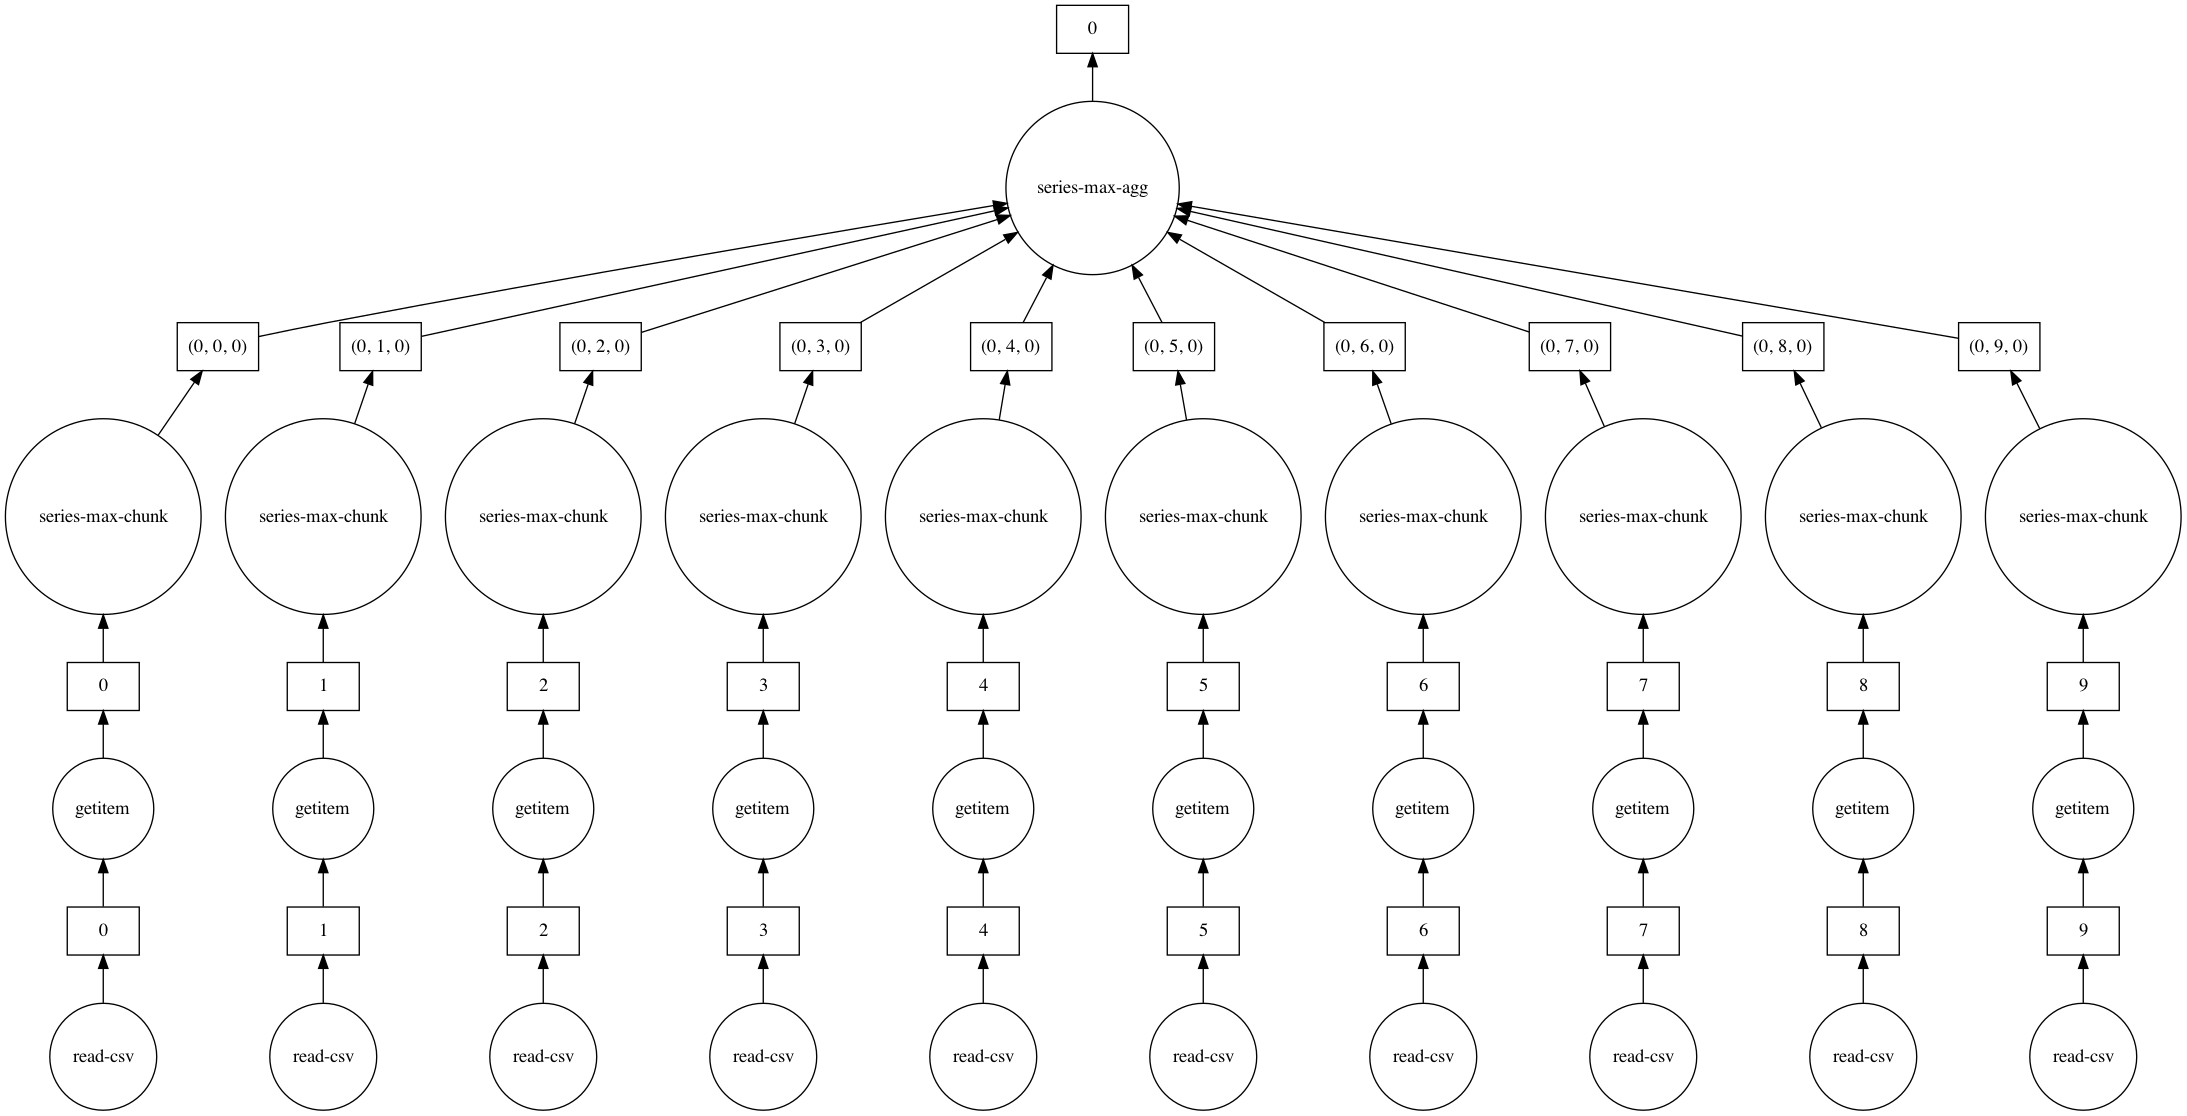

In [91]:
df.DepDelay.max().visualize(filename='../images/max_dask.png')

In [92]:
len(df[~df.Cancelled])

2540961

In [ ]:
luego os lo pongo

In [100]:
df.groupby('Origin').DepDelay.mean().compute()

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [101]:
no_cancelado=df[~df.Cancelled]

media_delay=no_cancelado.DepDelay.mean()
std_delay=no_cancelado.DepDelay.std()

In [102]:
std_delay

dd.Scalar<series-..., dtype=float64>

In [103]:
%%time
media_delay.compute()

CPU times: user 6.72 s, sys: 1.51 s, total: 8.23 s
Wall time: 5.88 s


9.206602541321965

In [105]:
%%time
std_delay.compute()

CPU times: user 6.81 s, sys: 1.55 s, total: 8.36 s
Wall time: 5.72 s


28.974539774551456

In [106]:
%%time

media_res, std_res = dask.compute(media_delay, std_delay)

CPU times: user 6.73 s, sys: 1.44 s, total: 8.17 s
Wall time: 5.31 s


In [107]:
media_res

9.206602541321965

In [108]:
std_res

28.974539774551456

In [109]:
type(std_res)

numpy.float64

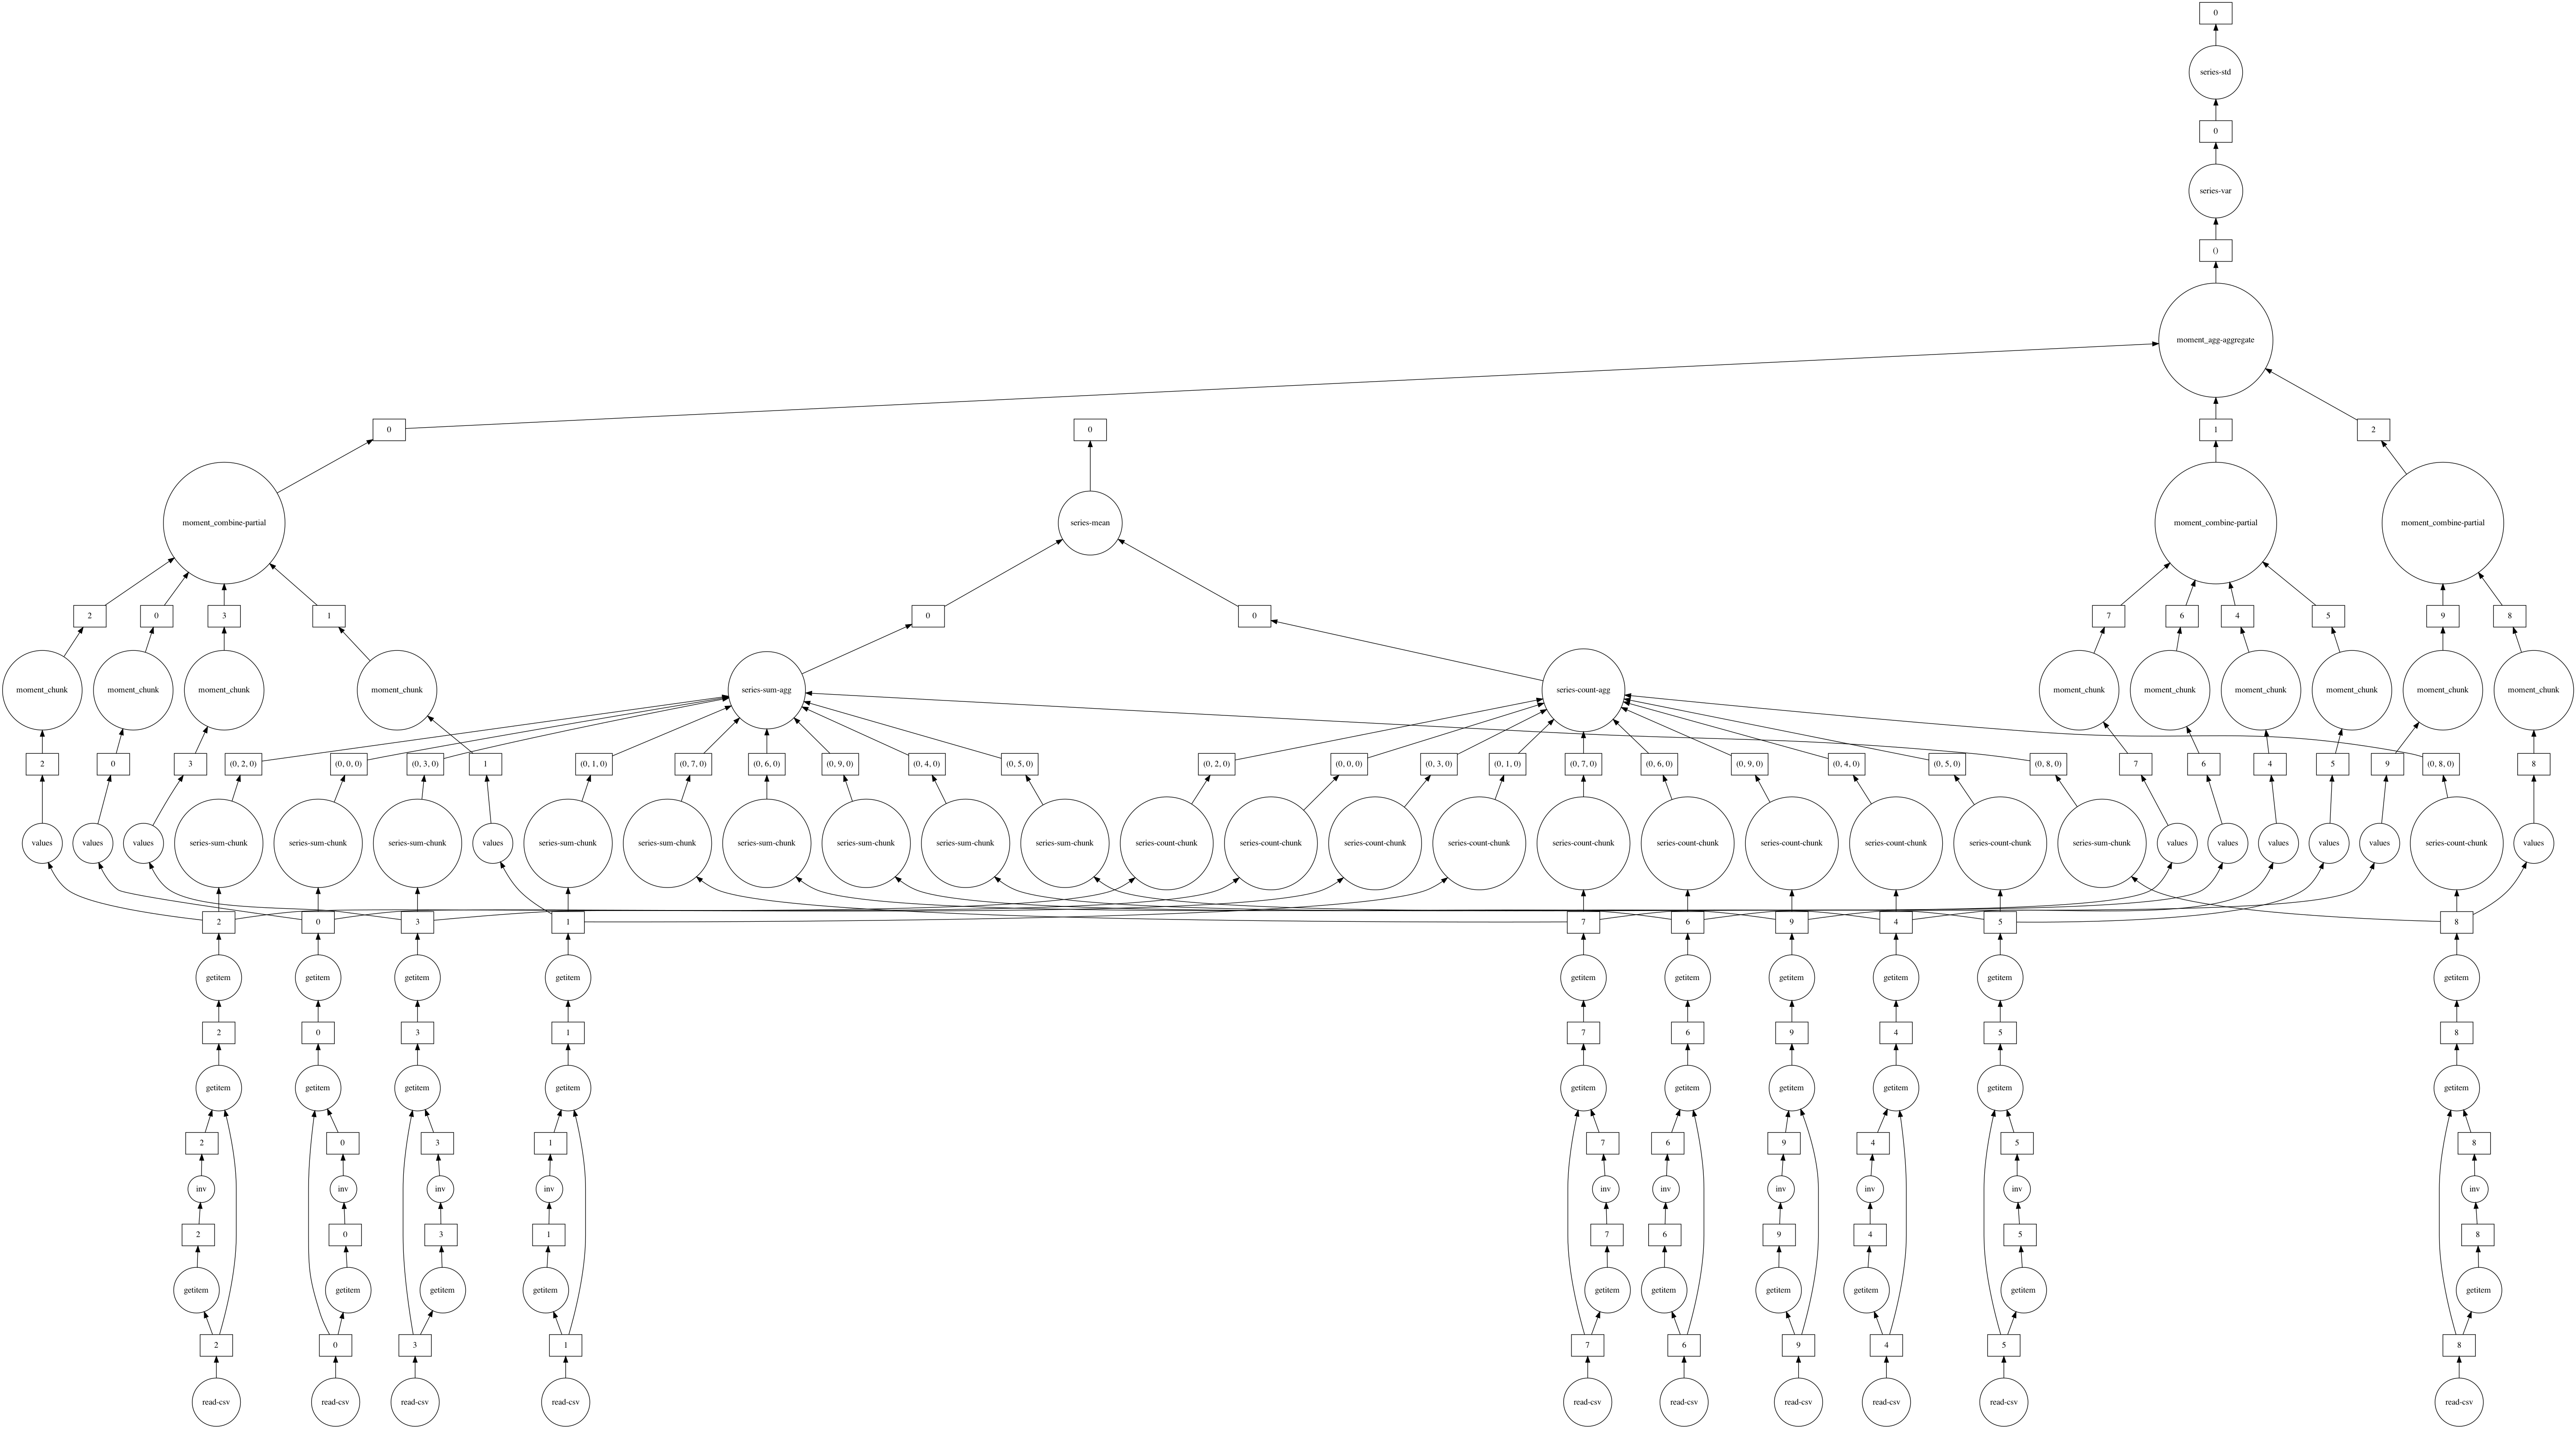

In [110]:
dask.visualize(media_delay, std_delay, filename='../images/std_dask.png')

# HDFS y Parquet  (sistemas de archivos)

In [118]:
%%time

df_csv=dd.read_csv(archivos)
df_csv.head()

CPU times: user 239 ms, sys: 55.4 ms, total: 294 ms
Wall time: 549 ms


,id,names,amount
0,23,Ursula,1380
1,92,Tim,-178
2,239,Alice,-784
3,260,Michael,-249
4,314,Jerry,1299


In [112]:
target=os.path.join('../datasets', 'accounts.h5')

In [113]:
%%time

df_csv.to_hdf(target, key='../datasets')

CPU times: user 4.25 s, sys: 847 ms, total: 5.09 s
Wall time: 33.4 s


['../datasets/accounts.h5',
 '../datasets/accounts.h5',
 '../datasets/accounts.h5']

In [116]:
%%time

df_h=dd.read_hdf(target, key='../datasets')
df_h.head()

CPU times: user 849 ms, sys: 112 ms, total: 961 ms
Wall time: 1.28 s


,id,names,amount
0,23,Ursula,1380
1,92,Tim,-178
2,239,Alice,-784
3,260,Michael,-249
4,314,Jerry,1299


In [117]:
df_h.info(memory_usage='deep')

<class 'dask.dataframe.core.DataFrame'>
Columns: 3 entries, id to amount
dtypes: object(1), int64(2)
memory usage: 91.6 MB


In [120]:
%%time
df_h.amount.sum().compute()

CPU times: user 2.46 s, sys: 304 ms, total: 2.76 s
Wall time: 3.23 s


3101435607

In [121]:
# parquet
# pip install fastparquet

In [122]:
target=os.path.join('../datasets', 'accounts.parquet')

df_csv.categorize(columns=['names']).to_parquet(target, 
                                               storage_options={'has_nulls':True},
                                               engine='fastparquet')

In [123]:
%%time

df_p=dd.read_parquet(target)
df_p.head()

CPU times: user 568 ms, sys: 38.8 ms, total: 607 ms
Wall time: 751 ms


,id,names,amount
0,23,Ursula,1380
1,92,Tim,-178
2,239,Alice,-784
3,260,Michael,-249
4,314,Jerry,1299


In [124]:
df_csv.info(memory_usage='deep')

<class 'dask.dataframe.core.DataFrame'>
Columns: 3 entries, id to amount
dtypes: object(1), int64(2)
memory usage: 68.7 MB


In [125]:
df_h.info(memory_usage='deep')

<class 'dask.dataframe.core.DataFrame'>
Columns: 3 entries, id to amount
dtypes: object(1), int64(2)
memory usage: 91.6 MB


In [126]:
df_p.info(memory_usage='deep')

<class 'dask.dataframe.core.DataFrame'>
Columns: 3 entries, id to amount
dtypes: category(1), int64(2)
memory usage: 71.5 MB


In [127]:
%%time

df_csv.amount.sum().compute()

CPU times: user 716 ms, sys: 208 ms, total: 925 ms
Wall time: 582 ms


3101435607

In [130]:
%%time

df_h.amount.sum().compute()

CPU times: user 2.48 s, sys: 318 ms, total: 2.8 s
Wall time: 3.68 s


3101435607

In [128]:
%%time

df_p.amount.sum().compute()

CPU times: user 50.9 ms, sys: 39.9 ms, total: 90.8 ms
Wall time: 212 ms


3101435607

# tqdm

In [131]:
#pip install tqdm

In [137]:
from tqdm.notebook import tqdm
import time

In [139]:
for i in tqdm(range(2), desc='Primer loop'):
    #tqdm._instances.clear()   # limpiar la barra
    for j in tqdm(range(5), desc='Segundo loop'):
        time.sleep(.5)

In [140]:
lst=[i for i in range(46)]

In [142]:
for e in tqdm(lst):
    time.sleep(.5)

In [143]:
df=pd.DataFrame(np.random.randint(0, int(1e8), (10000, 1000)))
df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,74289457,71636409,92167183,25005025,35773581,62521483,72774766,51639635,82977911,86220499,...,57404524,3312215,68605834,42735384,77870931,5585936,85858557,74587599,36933179,58728175
1,77139267,88394458,49782909,3635663,8106464,49846026,684309,45161123,85332969,28783430,...,92915059,83559404,87005245,62814235,62048259,25728697,30690610,94124928,38585558,30295144
2,38755302,33834468,1390125,11840400,85945813,31645954,33903395,18751970,83508750,18933980,...,90817384,71998628,40605764,3102235,62440681,64573529,59568912,82111262,13413419,98690391
3,15898749,3635624,45559585,2095073,70851698,81931109,36951486,76001897,13971287,43116465,...,16979504,73400754,69523928,1513554,76733492,16148279,68987604,5790347,27803704,95704926
4,94514183,7252866,35262785,24107033,96515314,76697977,67937816,3495058,84653278,3393757,...,80098449,44512228,36105889,36138490,66644593,23602641,48693003,95320186,89115405,10535429


In [144]:
tqdm.pandas()

df.groupby(0).progress_apply(lambda x: x**2)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,5518923421354849,5131775094415281,8494789622155489,625251275250625,1279749097563561,3908935836519289,5296166566354756,2666651902933225,6885333713923921,7433974447809001,...,3295279375666576,10970768206225,4706760458835556,1826313045627456,6063881894806761,31202680996096,7371691810122249,5563309924584801,1364059711046041,3448998538830625
1,5950466513297289,7813580205113764,2478338028502281,13218045449569,65714758583296,2484626307992676,468278807481,2039527030621129,7281715598354961,828485842564900,...,8633208188973481,6982173996835216,7569912657510025,3945628118635225,3849986444931081,661965849317809,941913542172100,8859502071005184,1488845286171364,917795749980736
2,1501973433111204,1144771224843024,1932447515625,140195072160000,7386682772230969,1001466404570116,1149440192526025,351636378880900,6973711326562500,358495598640400,...,8247797236603456,5183802433882384,1648828070023696,9623861995225,3898838643743761,4169740647513841,3548455276863744,6742259347232644,179919809269561,9739793275732881
3,252770219765001,13217761869376,2075675785372225,4389330875329,5019963109483204,6712706621969881,1365412317608196,5776288347598609,195196860436369,1859029554096225,...,288303556086016,5387670687768516,4833576564549184,2290845710916,5888028794514064,260766914661841,4759289505660816,33528118380409,773045956119616,9159432860665476
4,8932930788157489,52604065213956,1243464005956225,581149040063089,9315205836518596,5882579675892529,4615546842849856,12215430423364,7166177476145284,11517586575049,...,6415761532205601,1981338441523984,1303635220480321,1305990459480100,4441501776135649,557084662174881,2371008541158009,9085937859074596,7941555408314025,110995264214041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2220311928674596,5999893483024,9759455801641764,965361802153984,335042053655716,4185640217682576,187869978925489,1633739860524304,3183130867854564,3748385767779844,...,5559977551476049,5615213610303441,1187883304656489,8571089728832400,9640465853143876,8645484399323409,2215551103868881,1718420021668900,1361143550155041,192176946584100
9996,7041749210747161,1407376650570361,335748966490116,6395610832788969,981187149744649,3091653130148496,28182900885049,5391714947176804,5871337140871801,9024063704285184,...,9933346239798276,4263990483380644,2714299653321481,4723667560000,51779868647329,1080189468807696,34602523876881,2640462210743184,1115535952129600,4032314008254016
9997,7426643375100625,3059087472124324,3329816013975364,2023711674976489,7410399445840329,122876382541444,1048963694268681,6228788787000976,218327664087225,5408919536257449,...,1267645385664064,436015116950625,6952212726804900,1828762603953156,4721763456277921,64824381746881,3307444152806689,2500076900591361,49562261762209,238787297129536
9998,2112203668286089,8861176632595329,9245000570657476,4242914880550921,5896611645202404,3757579660810000,335402486116009,3443790260321856,5704326218460100,5308006790132761,...,7491430118090304,1045252953658384,2834442230670400,4822309416122500,4223989570419529,3159099597633424,56295174066121,6168069008073025,2728536281864449,2932674994855684


# Vaex

https://towardsdatascience.com/how-to-analyse-100s-of-gbs-of-data-on-your-laptop-with-python-f83363dda94

**Data:** https://vaex.io/docs/datasets.html

**si no plotea...:** https://stackoverflow.com/questions/57323126/how-to-do-interactive-2d-scatter-plot-zoom-point-selection-in-vaex

In [145]:
import vaex

import numpy as np
import pylab as plt
import seaborn as sns

In [146]:
%%time
#tamaño del archivo
!ls -l -h ../datasets/yellow_taxi_2015_f32s.hdf5

-rw-r--r--@ 1 iudh  staff    12G 14 mar 13:43 ../datasets/yellow_taxi_2015_f32s.hdf5
CPU times: user 8.91 ms, sys: 15.5 ms, total: 24.4 ms
Wall time: 502 ms


In [147]:
%%time

df=vaex.open('../datasets/yellow_taxi_2015_f32s.hdf5')
df

CPU times: user 410 ms, sys: 145 ms, total: 555 ms
Wall time: 4.87 s


#,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,payment_type,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,'VTS',2014-12-16 02:26:00.000000000,2014-12-16 02:28:00.000000000,1,'CSH',1.090000033378601,-73.98672485351562,40.75642013549805,1.0,nan,-73.9964599609375,40.74289321899414,5.0,0.5,0.5,0.0,0.0,6.0
1,'VTS',2014-12-15 18:23:00.000000000,2014-12-15 18:58:00.000000000,2,'',6.28000020980835,-74.00418853759766,40.72119140625,1.0,nan,-73.97000122070312,nan,nan,nan,nan,nan,nan,nan
2,'VTS',2015-01-15 19:05:39.000000000,2015-01-15 19:23:42.000000000,1,'1',1.590000033378601,-73.993896484375,40.7501106262207,1.0,0.0,-73.97478485107422,40.75061798095703,12.0,1.0,0.5,3.25,0.0,17.049999237060547
3,'CMT',2015-01-10 20:33:38.000000000,2015-01-10 20:53:28.000000000,1,'1',3.299999952316284,-74.00164794921875,40.7242431640625,1.0,0.0,-73.99441528320312,40.75910949707031,14.5,0.5,0.5,2.0,0.0,17.799999237060547
4,'CMT',2015-01-10 20:33:38.000000000,2015-01-10 20:43:41.000000000,1,'2',1.7999999523162842,-73.96334075927734,40.80278778076172,1.0,0.0,-73.95182037353516,40.82441329956055,9.5,0.5,0.5,0.0,0.0,10.800000190734863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"146,112,986",'VTS',2015-12-31 23:59:56.000000000,2016-01-01 00:08:18.000000000,5,'1',1.2000000476837158,-73.99381256103516,40.72087097167969,1.0,0.0,-73.98621368408203,40.722469329833984,7.5,0.5,0.5,1.7599999904632568,0.0,10.5600004196167
"146,112,987",'CMT',2015-12-31 23:59:58.000000000,2016-01-01 00:05:19.000000000,2,'2',2.0,-73.96527099609375,40.76028060913086,1.0,0.0,-73.93951416015625,40.75238800048828,7.5,0.5,0.5,0.0,0.0,8.800000190734863
"146,112,988",'CMT',2015-12-31 23:59:59.000000000,2016-01-01 00:12:55.000000000,2,'2',3.799999952316284,-73.98729705810547,40.739078521728516,1.0,0.0,-73.9886703491211,40.69329833984375,13.5,0.5,0.5,0.0,0.0,14.800000190734863
"146,112,989",'VTS',2015-12-31 23:59:59.000000000,2016-01-01 00:10:26.000000000,1,'2',1.9600000381469727,-73.99755859375,40.72569274902344,1.0,0.0,-74.01712036132812,40.705322265625,8.5,0.5,0.5,0.0,0.0,9.800000190734863


In [148]:
%%time

df.plot_widget(df.pickup_longitude,
               df.pickup_latitude,
               backend='bqplot',
               shape=512,
               limits=[[-74.05, -73.75], [40.58, 40.90]],
               f='log1p',
               colormap='plasma')

CPU times: user 957 ms, sys: 175 ms, total: 1.13 s
Wall time: 5.43 s


Heatmap(children=[ToolsToolbar(interact_value=None, supports_normalize=False, template='<template>\n  <v-toolb…

In [ ]:
%%time

df.describe()

In [ ]:
%%time

df.trip_distance.mean()